# 04.1 Lattice Sun

## 0. Initialization
Importing all necessary libraries and specifying the inputs

In [13]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from ladybug.sunpath import Sunpath
from scipy.interpolate import RegularGridInterpolator
import digital_twinning as dt
import pandas as pd
import topogenesis as tg



## 1. Import Meshes (context + envelope)

### 1.1. Load Meshes

In [14]:
#loading envelope and context from obj 
envelope_path = os.path.relpath('../data/OBJ_files/building_envelope.obj')
context_path = os.path.relpath('../data/OBJ_files/final_BAG3D.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


## 2. Import Lattice (envelope)

### 2.1. Load the Envelope Lattice

In [15]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/CSV_files/voxelized_envelope.csv')

envelope_lattice = tg.lattice_from_csv(lattice_path)

#setting the full lattice 
full_lattice = envelope_lattice * 0 + 1

### 2.2. Visualize the Context Mesh + Envelope Lattice

In [16]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the context mesh: white
p.add_mesh(dt.tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show(use_ipyvtk=True)


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(84702.22192807864, 448135.0034280786, 328.2819280786408),
 (84384.44, 447817.2215, 10.5),
 (0.0, 0.0, 1.0)]

## 3. Sun Vectors


### 3.1. import Sun Vectors

In [32]:

sun_rays_df = pd.read_csv('../data/CSV_files/sun_hits.csv')
sun_rays_df.set_index('Unnamed: 0', inplace=True)

sun_rays = np.array(sun_rays_df)

## 5. Aggregate Simulation Result in the Sun Access Lattice and shadow access lattice

### 5.1. Compute the percentage of time that each voxel sees the sun¶


In [33]:
sun_vectors = dt.sun_positions()


In [34]:
# constructing the sun direction from the sun vectors in a numpy array
sun_dirs = np.array(sun_vectors)
# exract the centroids of the envelope voxels
vox_cens = envelope_lattice.centroids
# next step we need to shoot in all of the sun directions from all of the voxels. To do so, we need to repeat the sun direction for the number of voxels to construct all ray directions (ray_dir). Also, we need to repeat the voxels for the amount of rays that it will receive. This results in a total amount of rays to be shooted (ray_src).  

ray_dir = np.tile(sun_dirs, [len(vox_cens),1])
ray_src = np.tile(vox_cens, [1, len(sun_dirs)]).reshape(-1, 3)


print("number of voxels to shoot rays from :",vox_cens.shape)
print("number of rays per each voxel :",sun_dirs.shape)
print("number of rays to be shooted :",ray_src.shape)

number of voxels to shoot rays from : (287, 3)
number of rays per each voxel : (158, 3)
number of rays to be shooted : (45346, 3)


In [35]:
# Further info: this is the vectorised version of nested for loops
hits = np.full((len(ray_dir)), 0)
hits[sun_rays] = 1
hits = hits.reshape(len(vox_cens), -1)
voxel_hits = np.sum(hits, axis=1)
# vox_sun_acc = 1.0 - voxel_hits / len(sun_dirs)
vox_sun_acc = 1.0 - voxel_hits / max(voxel_hits)

### 5.2.1 Store sun access information in a Lattice

In [40]:
# Further info: this is the vectorised version of nested for loops
env_all_vox_id = envelope_lattice.indices.flatten()
env_all_vox = envelope_lattice.flatten()
env_in_vox_id = env_all_vox_id[env_all_vox]
sunacc_array = np.full(env_all_vox.shape, 0.0)
sunacc_array[env_in_vox_id] = vox_sun_acc


# reshape to lattice shape
sunacc_array = sunacc_array.reshape(envelope_lattice.shape)

# convert to lattice
sunacc_lattice = tg.to_lattice(sunacc_array, envelope_lattice)

negative_lattice = envelope_lattice - 1
sunacc_lattice = sunacc_lattice + negative_lattice

### 5.3. Visualize the sun access lattice

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

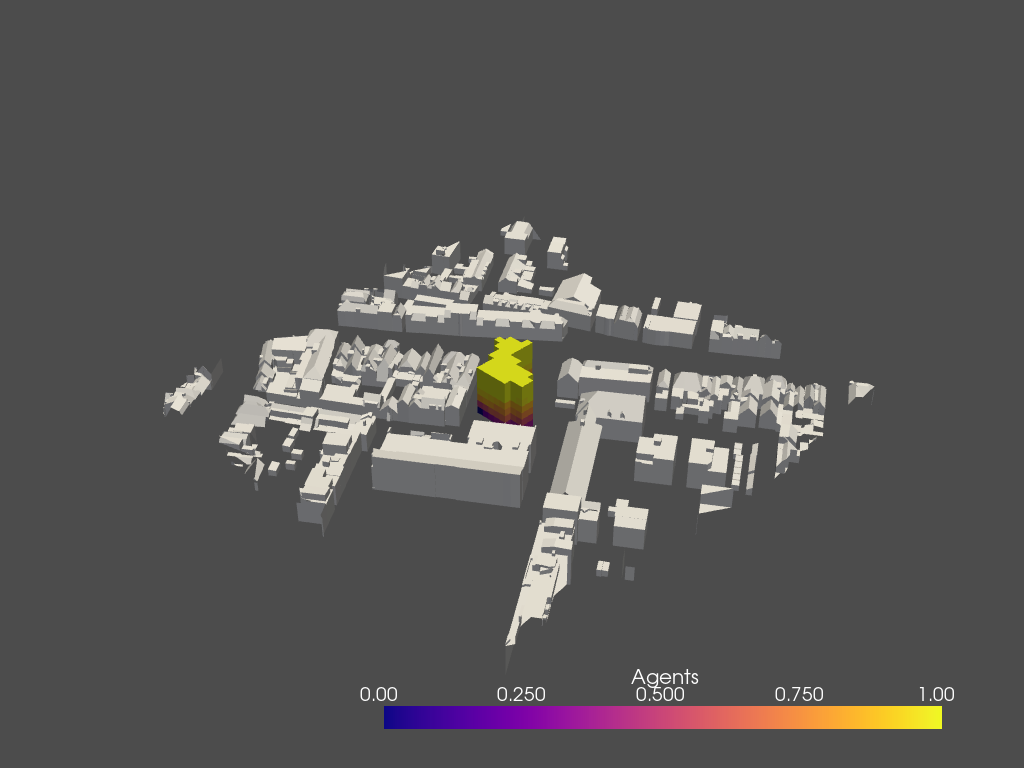

[(84702.085285897, 448134.866785897, 328.8957858969961),
 (84384.44, 447817.2215, 11.2505),
 (0.0, 0.0, 1.0)]

In [41]:
# initiating the plotter
p = pv.Plotter(notebook=True)

base_lattice = sunacc_lattice

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = sunacc_lattice.unit

# Add the data values to the cell data
grid.cell_arrays["Agents"] = sunacc_lattice.flatten(order="F") # Flatten the array!
# filtering the voxels
threshed = grid.threshold([0.000, 1.0])

# adding the voxels
p.add_mesh(threshed, cmap='plasma', name='sphere', show_edges=False, opacity=1.0, show_scalar_bar=True)
# adding the context mesh
p.add_mesh(dt.tri_to_pv(context_mesh), opacity=1)

# plotting
p.show(use_ipyvtk=True)

#saving and plotting
png_path = os.path.relpath('../lattice_sun_access.png')
p.show(screenshot= png_path)

In [23]:
# save the sun access lattice to csv
lattice_dir = '../data/CSV_files/sun_access.csv'
dt.save_to_clean_csv(sunacc_lattice, lattice_dir)

### Credits

In [24]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__editor__ = 'Siebren Meines'
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Interpolation of sun and shadow"